In [2]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from copy import deepcopy
import pickle as pkl
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import sys
from shapely.geometry import Point, Polygon, LineString

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from mcts.mcts import MCTS
from car import Car
from ooi import OOI

In [2]:
# Test plotting and update of car

# Create car
car = Car(None, [0.,0.], 0.)

# Animate the car
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
car_bottom_left = (car.position[0] - car.length/2, car.position[1] - car.width/2)
car_patch = ax.add_patch(patches.Rectangle(car_bottom_left, car.length, car.width, angle=car.yaw, rotation_point='center', color='red'))
plt.close()
def animate(i):
    car.update(0.5, [0.1, 45])
    car_bottom_left = (car.position[0] - car.length/2, car.position[1] - car.width/2)
    car_patch.set_xy(car_bottom_left)
    car_patch.set_angle(np.degrees(car.yaw))
    
    return car_patch

ani = FuncAnimation(fig, animate, frames=100, interval=100)

# Display the animation in the notebook
display(HTML(ani.to_jshtml()))

In [3]:
# Test plotting and update of car with pure pursuit

# Create car
car = Car(None, [0.,0.], 0.)

# Pick target point
target = np.array([7., 3.])

# Animate the car
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
car_bottom_left = (car.position[0] - car.length/2, car.position[1] - car.width/2)
car_patch = ax.add_patch(patches.Rectangle(car_bottom_left, car.length, car.width, angle=car.yaw, rotation_point='center', color='red'))
target_patch = ax.add_patch(patches.Circle(target, 0.1, color='blue'))
plt.close()
def animate(i):
    car.update_pure_pursuit(0.1, target)
    car_bottom_left = (car.position[0] - car.length/2, car.position[1] - car.width/2)
    car_patch.set_xy(car_bottom_left)
    car_patch.set_angle(np.degrees(car.yaw))
    
    return car_patch, target_patch

ani = FuncAnimation(fig, animate, frames=100, interval=100)

# Display the animation in the notebook
display(HTML(ani.to_jshtml()))

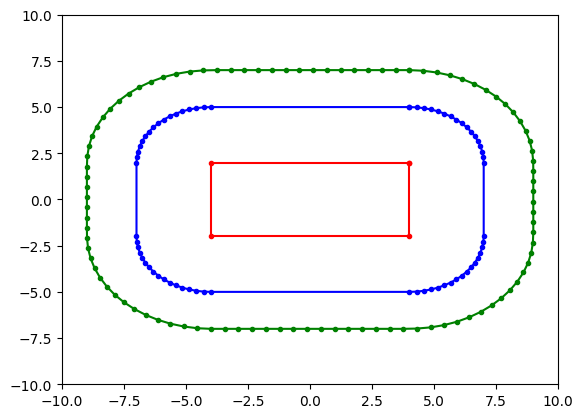

In [21]:
# Create an ooi and test path following around it.
ooi = OOI(None, [0., 0.])

# Plot ooi and buffere around it using shapely
ooi_poly = ooi.get_collision_polygon()
inner_path = np.array(ooi_poly.exterior.coords)
buffered_ooi_poly = ooi_poly.buffer(3)
outer_path = np.array(buffered_ooi_poly.exterior.coords)
more_buffered_ooi_poly = ooi_poly.buffer(5)
very_outer_path = np.array(more_buffered_ooi_poly.exterior.coords)

# Interpolate the outer most path
very_outer_line = LineString(very_outer_path)

# Densify the LineString by interpolating additional points
num_points = 100
densified_coords = [very_outer_line.interpolate(float(i) / num_points, normalized=True).coords[0] for i in range(num_points + 1)]
very_outer_path = np.array(densified_coords)
# Plot the ooi and the buffered ooi
fig, ax = plt.subplots()
ax.clear()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.plot(inner_path[:,0], inner_path[:,1], 'r', marker='.')
ax.plot(outer_path[:,0], outer_path[:,1], 'b', marker='.')
ax.plot(very_outer_path[:,0], very_outer_path[:,1], 'g', marker='.')

In [2]:
def get_interpolated_polygon_points(polygon: Polygon, num_points: int = 200):
    line = LineString(polygon.exterior.coords)
    densified_coords = [line.interpolate(float(i) / num_points, normalized=True).coords[0] for i in range(num_points + 1)]
    return np.array(densified_coords)

In [3]:
# Test plotting and update of car following a path around an ooi

# Setup plotting
fig, ax = plt.subplots()
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

# Create car
car = Car(None, [-15.,-15.], 150.)
car_state = car.get_state()

# Create an ooi
ooi = OOI(None, [0., 0.])

# Get ooi polygon and buffer it
ooi_poly = ooi.get_collision_polygon()
buffered_ooi_poly = ooi_poly.buffer(4)
path = get_interpolated_polygon_points(buffered_ooi_poly, 200)

# Plot the ooi and the buffered ooi
ooi_patch = ax.add_patch(patches.Polygon(ooi_poly.exterior.coords, color='red', fill=False))
buffered_ooi_patch = ax.add_patch(patches.Polygon(buffered_ooi_poly.exterior.coords, color='blue', fill=False))

# Plot the car
car_bottom_left = (car.position[0] - car.length/2, car.position[1] - car.width/2)
car_patch = ax.add_patch(patches.Rectangle(car_bottom_left, car.length, car.width, angle=np.degrees(car.yaw), rotation_point='center', color='red'))
target_patch = ax.add_patch(patches.Circle((0,0), 0.1, color='blue'))

# Close the initial plot and use the animation
plt.close()

def animate(i):
    global car_state
    action, target_point = car.get_action_follow_path(path, 4., simulate=True, starting_state=car_state, return_target_point=True)
    car_state = car.update(0.1, action, simulate=True, starting_state=car_state)
    target_patch.set_center(target_point)
    car_bottom_left = (car_state[0] - car.length/2, car_state[1] - car.width/2)
    car_patch.set_xy(car_bottom_left)
    car_patch.set_angle(np.degrees(car_state[2]))
    
    return car_patch, target_patch

ani = FuncAnimation(fig, animate, frames=100, interval=100)

# Display the animation in the notebook
display(HTML(ani.to_jshtml()))